In [1]:
pip install matplotlib pylatexenc

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from qiskit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit.synthesis import (SuzukiTrotter, LieTrotter)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
warnings.filterwarnings("ignore")

In [23]:
def get_hamiltonian(nqubits, J, h, alpha):
    ZZ_tuples=[("ZZ", [i,i+1], -J) for i in range(0,nqubits-1)]
    Z_tuples=[("Z", [i], -h*np.sin(alpha)) for i in range(0,nqubits)]
    X_tuples=[("X", [i], -h*np.cos(alpha)) for i in range(0,nqubits)]
    hamiltonian=SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=nqubits)
    return hamiltonian.simplify()

In [24]:
n_qubits=6
hamiltonian=get_hamiltonian(nqubits=n_qubits, J=0.2, h=1.2, alpha=np.pi/8.0)
hamiltonian

SparsePauliOp(['IIIIZZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZZIIII', 'IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIIX', 'IIIIXI', 'IIIXII', 'IIXIII', 'IXIIII', 'XIIIII'],
              coeffs=[-0.2       +0.j, -0.2       +0.j, -0.2       +0.j, -0.2       +0.j,
 -0.2       +0.j, -0.45922012+0.j, -0.45922012+0.j, -0.45922012+0.j,
 -0.45922012+0.j, -0.45922012+0.j, -0.45922012+0.j, -1.10865544+0.j,
 -1.10865544+0.j, -1.10865544+0.j, -1.10865544+0.j, -1.10865544+0.j,
 -1.10865544+0.j])

In [25]:
num_timesteps=60
evolution_time=30.0
dt=num_timesteps/evolution_time
product_formula_lt=LieTrotter()
product_formula_st2=SuzukiTrotter(2)
product_formula_st4=SuzukiTrotter(4)

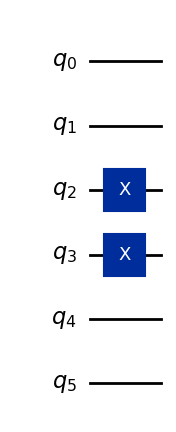

In [26]:
initial_circuit=QuantumCircuit(n_qubits)
initial_circuit.prepare_state("001100")
initial_circuit.decompose(reps=1).draw('mpl')

Trotter step with Lie Trotter
          -----------------------------
          Depth: 17
          Gate count: 27
          Nonlocal gate count: 10
          Gate breakdown: U: 12, CX: 10, P: 5
          


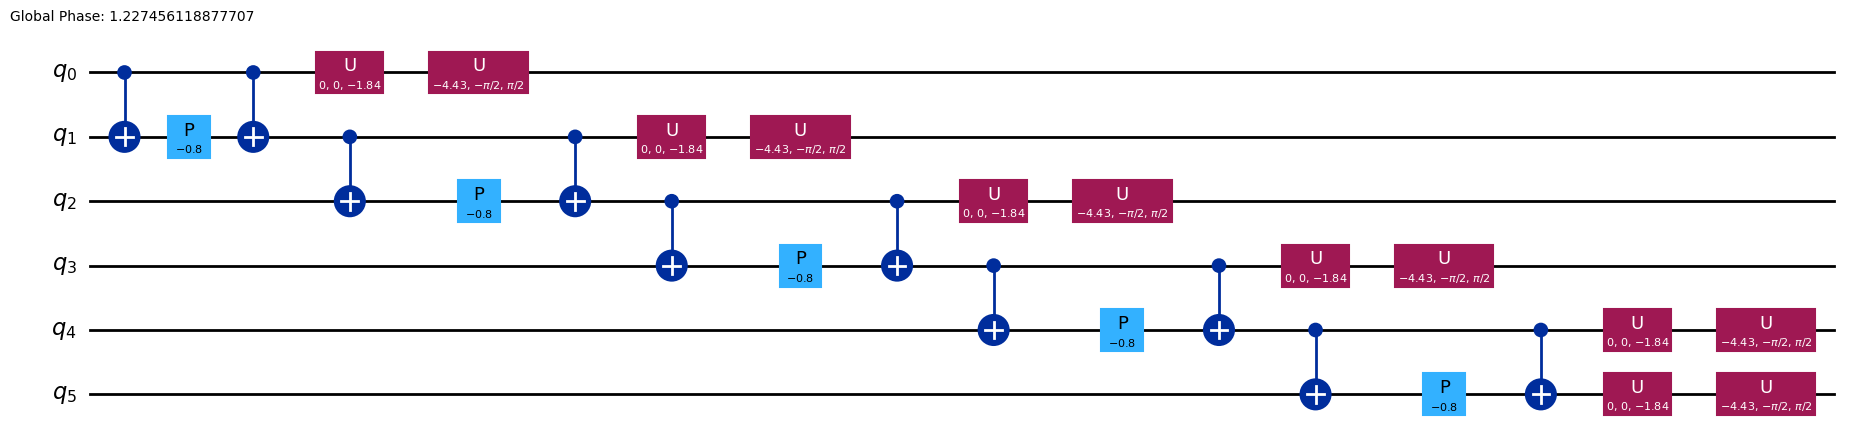

In [27]:
single_step_evolution_gates_lt=PauliEvolutionGate(hamiltonian, dt, synthesis=product_formula_lt)
single_step_evolution_lt=QuantumCircuit(n_qubits)
single_step_evolution_lt.append(single_step_evolution_gates_lt, single_step_evolution_lt.qubits)
print(f"""Trotter step with Lie Trotter
          -----------------------------
          Depth: {single_step_evolution_lt.decompose(reps=3).depth()}
          Gate count: {len(single_step_evolution_lt.decompose(reps=3))}
          Nonlocal gate count: {single_step_evolution_lt.decompose(reps=3).num_nonlocal_gates()}
          Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in single_step_evolution_lt.decompose(reps=3).count_ops().items()])}
          """)
single_step_evolution_lt.decompose(reps=3).draw("mpl", fold=-1)

In [28]:
magnetization=SparsePauliOp.from_sparse_list([('Z', [i], 1.0) for i in range(0,n_qubits)], num_qubits=n_qubits)/n_qubits
correlation=SparsePauliOp.from_sparse_list([("ZZ", [i,i+1], 1.0) for i in range(0,n_qubits-1)], num_qubits=n_qubits)/(n_qubits-1)
print("magnetization : ", magnetization)
print("correlation : ", correlation)

magnetization :  SparsePauliOp(['IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII'],
              coeffs=[0.16666667+0.j, 0.16666667+0.j, 0.16666667+0.j, 0.16666667+0.j,
 0.16666667+0.j, 0.16666667+0.j])
correlation :  SparsePauliOp(['IIIIZZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZZIIII'],
              coeffs=[0.2+0.j, 0.2+0.j, 0.2+0.j, 0.2+0.j, 0.2+0.j])


In [29]:
evolved_state=QuantumCircuit(initial_circuit.num_qubits)
evolved_state.append(initial_circuit, evolved_state.qubits)
estimator=StatevectorEstimator()
shots=10000
precision=np.sqrt(1/shots)
energy_list=[]
mag_list=[]
corr_list=[]
job=estimator.run([(evolved_state, [hamiltonian, magnetization, correlation])], precision=precision)
evs=job.result()[0].data.evs
energy_list.append(evs[0])
mag_list.append(evs[1])
corr_list.append(evs[2])
for i in range(num_timesteps):
    evolved_state.append(single_step_evolution_gates_lt, evolved_state.qubits)
    job=estimator.run([(evolved_state, [hamiltonian, magnetization, correlation])], precision=precision)
    evs=job.result()[0].data.evs
    energy_list.append(evs[0])
    mag_list.append(evs[1])
    corr_list.append(evs[2])
energy_array=np.array(energy_list)
mag_array=np.array(mag_list)
corr_array=np.array(corr_list)

Text(0.5, 0.98, 'Observable evolution')

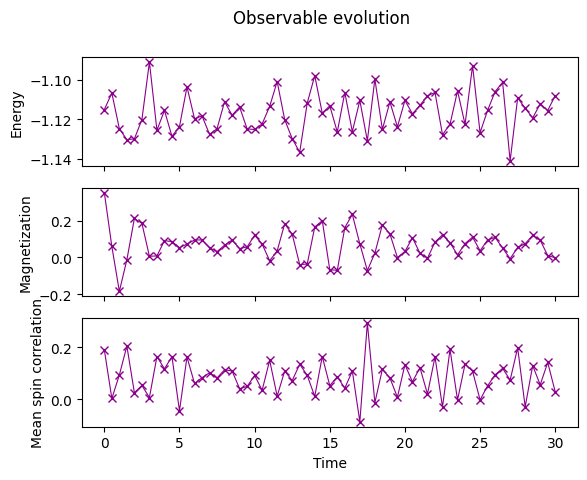

In [30]:
fig, axes = plt.subplots(3, sharex=True)
times = np.linspace(0, evolution_time, num_timesteps + 1)  # includes initial state
axes[0].plot(
    times,
    energy_array,
    label="First order",
    marker="x",
    c="darkmagenta",
    ls="-",
    lw=0.8,
)
axes[1].plot(
    times, mag_array, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[2].plot(
    times, corr_array, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[0].set_ylabel("Energy")
axes[1].set_ylabel("Magnetization")
axes[2].set_ylabel("Mean spin correlation")
axes[2].set_xlabel("Time")
fig.suptitle("Observable evolution")

Trotter step with second order Suzuki Trotter
          ---------------------------------------------
          Depth: 34
          Gate Count: 53
          Nonlocal gate count: 20
          Gate breakdown: U: 23, CX: 20, P: 10


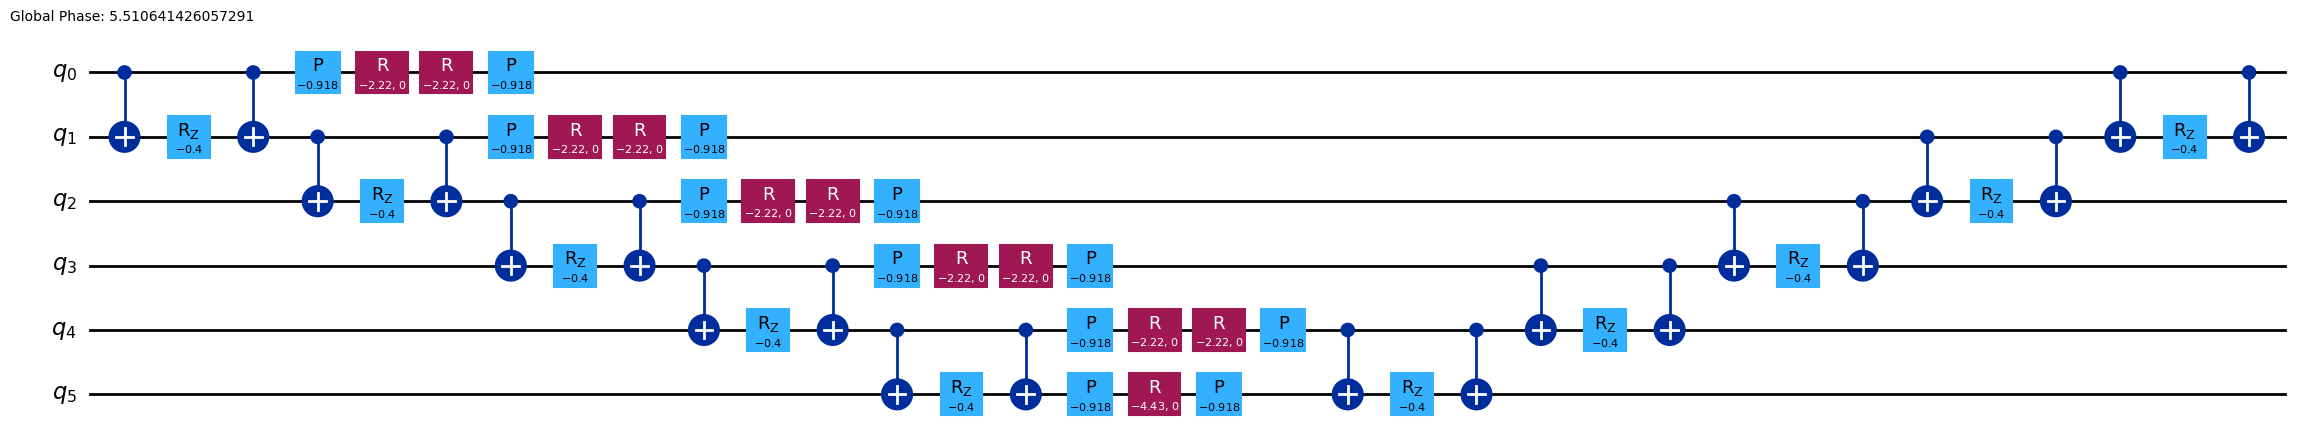

In [31]:
single_step_evolution_gates_st2=PauliEvolutionGate(hamiltonian, dt, synthesis=product_formula_st2)
single_step_evolution_st2=QuantumCircuit(n_qubits)
single_step_evolution_st2.append(single_step_evolution_gates_st2, single_step_evolution_st2.qubits)
print(f'''Trotter step with second order Suzuki Trotter
          ---------------------------------------------
          Depth: {single_step_evolution_st2.decompose(reps=3).depth()}
          Gate Count: {len(single_step_evolution_st2.decompose(reps=3))}
          Nonlocal gate count: {single_step_evolution_st2.decompose(reps=3).num_nonlocal_gates()}
          Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in single_step_evolution_st2.decompose(reps=3).count_ops().items()])}''')
single_step_evolution_st2.decompose(reps=2).draw('mpl', fold=-1)

In [37]:
evolved_state=QuantumCircuit(initial_circuit.num_qubits)
evolved_state.append(initial_circuit, evolved_state.qubits)
estimator=StatevectorEstimator()
shots=10000
precision=1/np.sqrt(shots)
energy_list_st2=[]
mag_list_st2=[]
corr_list_st2=[]
job=estimator.run([(evolved_state, [hamiltonian, magnetization, correlation])], precision=precision)
evs=job.result()[0].data.evs
energy_list_st2.append(evs[0])
mag_list_st2.append(evs[1])
corr_list_st2.append(evs[2])
for n in range(num_timesteps):
    evolved_state.append(single_step_evolution_gates_st2, single_step_evolution_st2.qubits)
    job=estimator.run([(evolved_state, [hamiltonian, magnetization, correlation])], precision=precision)
    evs=job.result()[0].data.evs
    energy_list_st2.append(evs[0])
    mag_list_st2.append(evs[1])
    corr_list_st2.append(evs[2])
energy_array_st2=np.array(energy_list_st2)
mag_array_st2=np.array(mag_list_st2)
corr_array_st2=np.array(corr_list_st2)

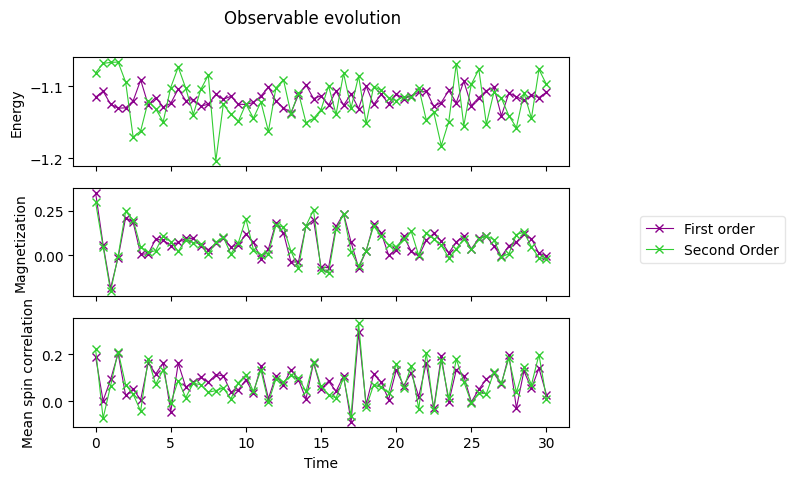

In [33]:
axes[0].plot(
    times,
    energy_array_st2,
    label="Second Order",
    marker="x",
    c="limegreen",
    ls="-",
    lw=0.8,
)
axes[1].plot(
    times,
    mag_array_st2,
    label="Second Order",
    marker="x",
    c="limegreen",
    ls="-",
    lw=0.8,
)
axes[2].plot(
    times,
    corr_array_st2,
    label="Second Order",
    marker="x",
    c="limegreen",
    ls="-",
    lw=0.8,
)

legend = fig.legend(
    *axes[0].get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig

In [38]:
exact_times = np.array(
    [
        0.0,
        0.3,
        0.6,
        0.8999999999999999,
        1.2,
        1.5,
        1.7999999999999998,
        2.1,
        2.4,
        2.6999999999999997,
        3.0,
        3.3,
        3.5999999999999996,
        3.9,
        4.2,
        4.5,
        4.8,
        5.1,
        5.3999999999999995,
        5.7,
        6.0,
        6.3,
        6.6,
        6.8999999999999995,
        7.199999999999999,
        7.5,
        7.8,
        8.1,
        8.4,
        8.7,
        9.0,
        9.299999999999999,
        9.6,
        9.9,
        10.2,
        10.5,
        10.799999999999999,
        11.1,
        11.4,
        11.7,
        12.0,
        12.299999999999999,
        12.6,
        12.9,
        13.2,
        13.5,
        13.799999999999999,
        14.1,
        14.399999999999999,
        14.7,
        15.0,
        15.299999999999999,
        15.6,
        15.899999999999999,
        16.2,
        16.5,
        16.8,
        17.099999999999998,
        17.4,
        17.7,
        18.0,
        18.3,
        18.599999999999998,
        18.9,
        19.2,
        19.5,
        19.8,
        20.099999999999998,
        20.4,
        20.7,
        21.0,
        21.3,
        21.599999999999998,
        21.9,
        22.2,
        22.5,
        22.8,
        23.099999999999998,
        23.4,
        23.7,
        24.0,
        24.3,
        24.599999999999998,
        24.9,
        25.2,
        25.5,
        25.8,
        26.099999999999998,
        26.4,
        26.7,
        27.0,
        27.3,
        27.599999999999998,
        27.9,
        28.2,
        28.5,
        28.799999999999997,
        29.099999999999998,
        29.4,
        29.7,
        30.0,
    ]
)
exact_energy = np.array(
    [
        -1.1184402376762155,
        -1.1184402376762157,
        -1.1184402376762157,
        -1.1184402376762148,
        -1.1184402376762153,
        -1.1184402376762155,
        -1.1184402376762148,
        -1.118440237676216,
        -1.118440237676216,
        -1.1184402376762166,
        -1.1184402376762148,
        -1.118440237676216,
        -1.1184402376762153,
        -1.1184402376762148,
        -1.118440237676217,
        -1.118440237676215,
        -1.1184402376762161,
        -1.1184402376762157,
        -1.118440237676217,
        -1.1184402376762161,
        -1.1184402376762137,
        -1.1184402376762161,
        -1.1184402376762161,
        -1.118440237676218,
        -1.1184402376762155,
        -1.1184402376762166,
        -1.1184402376762155,
        -1.1184402376762137,
        -1.1184402376762186,
        -1.1184402376762215,
        -1.1184402376762148,
        -1.118440237676216,
        -1.1184402376762166,
        -1.1184402376762148,
        -1.1184402376762121,
        -1.1184402376762166,
        -1.1184402376762181,
        -1.1184402376762137,
        -1.1184402376762148,
        -1.1184402376762193,
        -1.1184402376762108,
        -1.1184402376762144,
        -1.118440237676217,
        -1.1184402376762197,
        -1.1184402376762153,
        -1.1184402376762161,
        -1.1184402376762184,
        -1.1184402376762126,
        -1.118440237676214,
        -1.118440237676214,
        -1.1184402376762161,
        -1.118440237676212,
        -1.1184402376762164,
        -1.118440237676217,
        -1.1184402376762121,
        -1.1184402376762157,
        -1.1184402376762212,
        -1.1184402376762217,
        -1.1184402376762206,
        -1.118440237676222,
        -1.1184402376762166,
        -1.118440237676212,
        -1.1184402376762137,
        -1.11844023767622,
        -1.1184402376762206,
        -1.118440237676219,
        -1.1184402376762153,
        -1.1184402376762164,
        -1.118440237676209,
        -1.1184402376762144,
        -1.1184402376762161,
        -1.118440237676216,
        -1.1184402376762173,
        -1.118440237676214,
        -1.1184402376762093,
        -1.1184402376762184,
        -1.1184402376762126,
        -1.118440237676213,
        -1.1184402376762195,
        -1.1184402376762095,
        -1.1184402376762075,
        -1.1184402376762197,
        -1.1184402376762141,
        -1.1184402376762146,
        -1.1184402376762184,
        -1.118440237676218,
        -1.1184402376762224,
        -1.118440237676219,
        -1.118440237676218,
        -1.1184402376762206,
        -1.1184402376762168,
        -1.118440237676221,
        -1.118440237676218,
        -1.1184402376762148,
        -1.1184402376762106,
        -1.1184402376762173,
        -1.118440237676216,
        -1.118440237676216,
        -1.1184402376762113,
        -1.1184402376762275,
        -1.1184402376762195,
    ]
)
exact_magnetization = np.array(
    [
        0.3333333333333333,
        0.26316769633415005,
        0.0912947227110664,
        -0.09317712543141576,
        -0.20391854332115245,
        -0.19318196655046493,
        -0.06411527074401464,
        0.12558269854206197,
        0.28252754464640606,
        0.3264196194042506,
        0.2361586169847769,
        0.060894367906122224,
        -0.10842387093076275,
        -0.18636359582538073,
        -0.1338364343947887,
        0.020284606520827753,
        0.19151142743926025,
        0.2905341647678381,
        0.2723014646745304,
        0.15147481733047252,
        -0.008179102877790292,
        -0.1242999208732406,
        -0.1372529247781061,
        -0.04083616185958952,
        0.11066094926716476,
        0.23140661570567636,
        0.2587109403786205,
        0.1868237670027325,
        0.061201779383143744,
        -0.051391248969654205,
        -0.09843899603365061,
        -0.061297056158849166,
        0.04199010081939773,
        0.15861461430963147,
        0.22336830674799552,
        0.20179555623336537,
        0.11407111438609417,
        0.01609419104778282,
        -0.04239611796730001,
        -0.04249123521065924,
        0.008850291714888112,
        0.08780898151558082,
        0.1561486776507056,
        0.17627348772811832,
        0.13870676179652253,
        0.07205869195282538,
        0.018300003064909465,
        0.0001095640839572417,
        0.015157929316037586,
        0.05077755280969454,
        0.09245534457650838,
        0.12206907551110702,
        0.12284950557969157,
        0.09570215398601932,
        0.06294378255078983,
        0.045503313813986014,
        0.043389819499542556,
        0.046725117769796744,
        0.054956411358382404,
        0.0713814528253614,
        0.08743689703248492,
        0.08951216359166674,
        0.07878386475305985,
        0.06955669116405788,
        0.06639892435963689,
        0.05890378761746903,
        0.04541796525844558,
        0.0414221088331947,
        0.05499634106912299,
        0.07409418836014572,
        0.08371859070160165,
        0.08211623987959302,
        0.07615055161378328,
        0.06702584458783024,
        0.051891407742740085,
        0.038049378383635625,
        0.03825614149768043,
        0.054183218463525695,
        0.0753534475741016,
        0.08853147112587295,
        0.08767917178542013,
        0.07709383184439536,
        0.06308595032042386,
        0.0498812359204284,
        0.04299040064096167,
        0.04769159891460652,
        0.06483569572288776,
        0.08698035745435016,
        0.10047391641776235,
        0.09747255683203637,
        0.08098863187287358,
        0.05959496723987331,
        0.04383882265040485,
        0.04232138798062125,
        0.05720514169944535,
        0.08201306299870219,
        0.10274898262000469,
        0.10707552455080133,
        0.09210856128265357,
        0.06379922105742579,
        0.03624325103307953,
    ]
)
exact_correlation = np.array(
    [
        0.2,
        0.1247704225763532,
        0.01943938494098705,
        0.03854917181332821,
        0.11196616231067426,
        0.0906546700356683,
        0.01629373561896267,
        0.011352652889791095,
        0.0636185676540077,
        0.09543834437789013,
        0.10058518161011307,
        0.11829217731417431,
        0.1397812224038133,
        0.12316460402216707,
        0.08541383059335775,
        0.06144846844403662,
        0.020246372880505827,
        -0.02693683090021662,
        0.003919250903281282,
        0.1117419430168554,
        0.19676155181256794,
        0.18594408880783336,
        0.1002673802566004,
        0.03821525827438024,
        0.04485205090247377,
        0.05348102743040269,
        0.03160026140008638,
        0.033437649060464834,
        0.10486939975320728,
        0.20249469538955758,
        0.19735507621013149,
        0.0553097261765083,
        -0.04889114490131667,
        0.011685690974970964,
        0.11705971535823065,
        0.11681165998194759,
        0.06637091239560744,
        0.10936684225958895,
        0.20225454101061405,
        0.16284420833341812,
        -0.0025823294931362067,
        -0.0763416631752919,
        0.02985268630418397,
        0.15234468006771007,
        0.14606385406970995,
        0.0935341856492092,
        0.12325421854361143,
        0.17130422930386324,
        0.10383730044042278,
        -0.031333159406547614,
        -0.05241572078596815,
        0.07722509925347705,
        0.17642188574256007,
        0.12765340239966838,
        0.06309968945093776,
        0.11574687130499339,
        0.16978282647206913,
        0.0736143632571229,
        -0.05356602733119409,
        -0.0009649396796768892,
        0.15921620111869142,
        0.17760366431811037,
        0.04736297330213485,
        0.012122870263181897,
        0.13268065586830521,
        0.1728473023503636,
        0.03999259331072221,
        -0.036997053070222885,
        0.06951528580242439,
        0.1769169993516561,
        0.12290448295710298,
        0.012897784654866427,
        0.02859435620982225,
        0.12895847695150875,
        0.13629536955485938,
        0.05394621059822597,
        0.02298040588184324,
        0.07036499900317271,
        0.11706448623132719,
        0.10435285842074606,
        0.055721236329964965,
        0.04676334743672697,
        0.08417924910022263,
        0.10611161955304965,
        0.089304171047322,
        0.06098589533081194,
        0.06314519797488709,
        0.09431492621892917,
        0.09667836915967139,
        0.0651298357290882,
        0.05176966009147416,
        0.06727229484222669,
        0.08871788283607947,
        0.09907054249093444,
        0.09785167773502176,
        0.09277216140054353,
        0.07520999642062785,
        0.05894392248382922,
        0.07236135251622376,
        0.08608284185200156,
        0.07282922961856123,
    ]
)

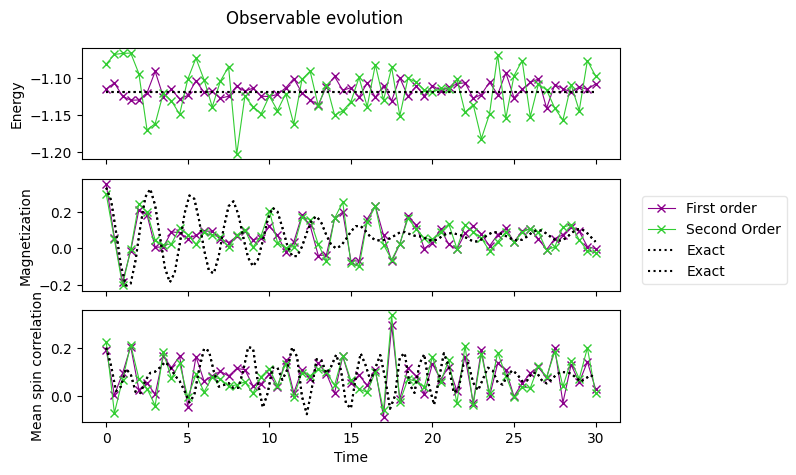

In [39]:
axes[0].plot(exact_times, exact_energy, c="k", ls=":", label="Exact")
axes[1].plot(exact_times, exact_magnetization, c="k", ls=":", label="Exact")
axes[2].plot(exact_times, exact_correlation, c="k", ls=":", label="Exact")
# Replace the legend
legend.remove()
# Select the labels of only the first axis
legend = fig.legend(
    *axes[0].get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig.tight_layout()
fig